In [80]:
from tensorflow.keras.layers import Dense,Flatten,Lambda,Input
from tensorflow.keras.models import Model

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [82]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [83]:
from sklearn.metrics import confusion_matrix

In [60]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/training/
   creating: dataset/training/cats/
  inflating: dataset/training/cats/cat.100.jpg  
  inflating: dataset/training/cats/cat.101.jpg  
  inflating: dataset/training/cats/cat.102.jpg  
  inflating: dataset/training/cats/cat.103.jpg  
  inflating: dataset/training/cats/cat.104.jpg  
  inflating: dataset/training/cats/cat.105.jpg  
  inflating: dataset/training/cats/cat.106.jpg  
  inflating: dataset/training/cats/cat.107.jpg  
  inflating: dataset/training/cats/cat.108.jpg  
  inflating: dataset/training/cats/cat.109.jpg  
  inflating: dataset/training/cats/cat.110.jpg  
  inflating: dataset/training/cats/cat.111.jpg  
  inflating: dataset/training/cats/cat.112.jpg  
  inflating: dataset/training/cats/cat.113.jpg  
  inflating: dataset/training/cats/cat.114.jpg  
  inflating: dataset/training/cats/cat.115.jpg  
  inflating: dataset/training/cats/cat.116.jpg  
  inflating: dataset/training/cats/cat.117.jpg  
  inflating: dataset/training

In [84]:
train_path="dataset/training"
valid_path="dataset/validation"

In [85]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')


In [86]:

IMAGE_SIZE = [300, 300] 
epochs = 10
batch_size = 32

In [87]:
folders = glob(train_path + '/*')

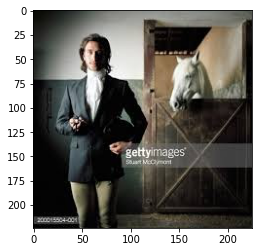

In [88]:

plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [89]:
resnet=ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layers in resnet.layers:
  layers.trainable=False

In [90]:
x=Flatten()(resnet.output)
x=Dense(1000,activation='relu')(x)
x=Dense(len(folders),activation='softmax')(x)
model=Model(inputs=resnet.input,outputs=x)

In [91]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [92]:
gen=ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [93]:
testgen=gen.flow_from_directory(directory=valid_path,target_size=IMAGE_SIZE)
print(testgen.class_indices)

Found 196 images belonging to 4 classes.
{'cats': 0, 'dogs': 1, 'horses': 2, 'humans': 3}


In [94]:
labels=[None]*len(folders)

In [95]:
labels

[None, None, None, None]

In [96]:
for k,v in testgen.class_indices.items():
  labels[v]=k

In [97]:
labels

['cats', 'dogs', 'horses', 'humans']

min: -123.68 max: 151.061
[1. 0. 0. 0.]


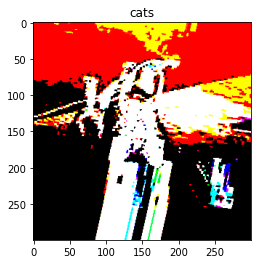

In [98]:
for x,y in testgen:
  print("min:", x[0].min(), "max:", x[0].max())
  print(y[0])
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [99]:
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 612 images belonging to 4 classes.


In [100]:

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 196 images belonging to 4 classes.


In [101]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [102]:
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/10
19/19 [==============================] - 283s 15s/step - loss: 51.4525 - accuracy: 0.6517 - val_loss: 15.8907 - val_accuracy: 0.8281
Epoch 2/10
19/19 [==============================] - 270s 14s/step - loss: 14.3177 - accuracy: 0.8741 - val_loss: 6.2718 - val_accuracy: 0.9323
Epoch 3/10
19/19 [==============================] - 264s 14s/step - loss: 5.6908 - accuracy: 0.9414 - val_loss: 10.4787 - val_accuracy: 0.8542
Epoch 4/10
19/19 [==============================] - 264s 14s/step - loss: 1.9021 - accuracy: 0.9672 - val_loss: 6.3362 - val_accuracy: 0.9115
Epoch 5/10
19/19 [==============================] - 264s 14s/step - loss: 1.0448 - accuracy: 0.9793 - val_loss: 4.2261 - val_accuracy: 0.9375
Epoch 6/10
19/19 [==============================] - 264s 14s/step - loss: 1.4335 - accuracy: 0.9655 - val_loss: 1.6188 - val_accuracy: 0.9635
Epoch 7/10
19/19 [==============================] - 264s 14s/step - loss: 1.5321 - accuracy: 0.9638 - val_loss: 3.2618 - val_accuracy: 0.9583
Ep

In [104]:
def get_confusion_matrix(data_path, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [105]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)



Generating confusion matrix 612
Found 612 images belonging to 4 classes.
2/2 [==============================] - 12s 1s/step
[[149   3   0   1]
 [  0 180   0   1]
 [  0   1 150   2]
 [  0   0   0 125]]
Generating confusion matrix 196
Found 196 images belonging to 4 classes.
1/1 [==============================] - 1s 1s/step
[[42  6  0  1]
 [ 1 20  0  0]
 [ 0  0 49  0]
 [ 0  0  0 77]]


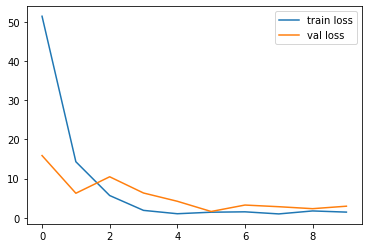

In [106]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

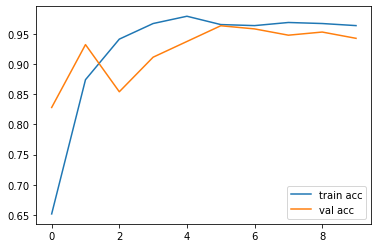

In [107]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
